## Fitbod Data Exploration

### Table of contents
a. [Load Data](http://localhost:8888/notebooks/Fitbod%20Exploration.ipynb#Load-Data)

b. [Initial Exploration & Data Cleaning](http://localhost:8888/notebooks/Fitbod%20Exploration.ipynb#Initial-Exploration-&-Data-Cleaning)

c. [Exploratory Data Analysis](http://localhost:8888/notebooks/Fitbod%20Exploration.ipynb#Initial-Exploration-&-Data-Cleaning)
    
    1. Workout data
    2. User data
    3. Modeling

d. [Personal data]()

### Import libraries

In [113]:
# Imports
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from itertools import combinations, permutations
import seaborn as sns

### Load Data

In [114]:
fitbod_data = pd.read_csv("fitbod_Joe_Cummings_20211217-105218.csv")
fitbod_data.head()

,Date,workoutId,exerciseId,singleSetId,exerciseName,reps,weight,fake_user_id
0,2021-03-07,Zg7ThO2Lv4,BTmBzxhAmZ,X5lF8xYXM5,Dumbbell Pullover,10,11.339823,fake_id_589
1,2021-04-01,DxxwhjbCGh,9VAkz3bNl4,MfilQC2kV0,Decline Push Up,15,0.000000,fake_id_545
2,2021-01-20,51rYwkwYlC,djuvlRHUvb,6Dkb9htFdu,Dumbbell Rear Delt Raise,9,13.607787,fake_id_559
3,2021-07-27,7BtpdMyeEi,DhkjvJNsNR,q3NKUngw7p,Sit Up,12,0.000000,fake_id_590
4,2021-11-03,X7WUFkJacr,otjt26R0oL,HA41FpHtp9,Barbell Shoulder Press,4,38.555397,fake_id_552


***
### Initial Exploration & Data Cleaning

#### The column names are a mix of camel-case, pascal-case, and snake-case. Nothing *explicitly* wrong with that, but it looks messy and could lead to confusion.

In [115]:
fitbod_data = fitbod_data.rename(columns={"Date": "date", "fake_user_id": "fakeUserId"})

#### Examine the datatypes

In [116]:
fitbod_data.dtypes

date             object
workoutId        object
exerciseId       object
singleSetId      object
exerciseName     object
reps              int64
weight          float64
fakeUserId       object
dtype: object

#### Working with 'date' as an object might be tricky...

In [117]:
fitbod_data.date = fitbod_data.date.astype("datetime64")

#### Are we missing any values?

In [268]:
fitbod_data.isnull().values.any()

False

#### Let's see how many samples there are in this dataset

In [118]:
fitbod_data.shape

(31426, 8)

#### Examine the distribution of the numerical variables

In [119]:
fitbod_data.describe()

,reps,weight
count,31426.000000,31426.000000
mean,11.360020,24.209276
std,7.507842,29.603537
min,0.000000,0.000000
25%,8.000000,0.000000
50%,10.000000,11.339823
75%,13.000000,38.555397
max,99.000000,195.000000


This is interesting as an overview, but reps and weight can be exceptionally specific to a given exercise so we can't draw any concrete conclusions from this distribution. 

Assumption 1: The unit of measurement for 'weight' is kilogram. The reasoning is that when I exported my own data (see later in the analysis), the weight is output in kilograms.

***
### Exploratory Data Analysis

### 1. Workout data

#### When were most of the workouts logged?

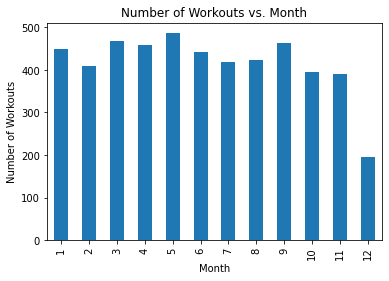

In [141]:
# Add a column just for month
fitbod_data["month"] = fitbod_data.date.dt.month

# Groupby workoutId first so we don't count each individual exercise as a workout
fbm = fitbod_data[["workoutId", "month", "fakeUserId"]].groupby(by="workoutId").first().reset_index()

# Get value counts of month
fbm_m = fbm.groupby(by="month").size()
fbm_m.plot(kind="bar")
plt.xlabel("Month")
plt.ylabel("Number of Workouts")
plt.title("Number of Workouts vs. Month")
plt.show()

The most workouts logged were in July! A bonus is that we can see that the least workouts were logged in December. Potential follow up questions: Are there any internal variables that could explain this dip? Did we have a high amount of churn in November? Did the app go down for a period of time? New feature released? 

#### In which month did the most users log workouts?

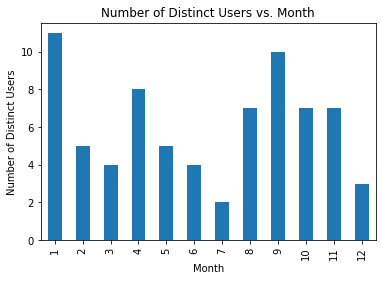

In [144]:
# We want to group the workouts by user
fbm_u = fbm.groupby(by="fakeUserId").first()

# Then, group by month and take the count
fbm_um = fbm_u.groupby(by="month").count()
fbm_um.plot(kind="bar", legend=None)
plt.xlabel("Month")
plt.ylabel("Number of Distinct Users")
plt.title("Number of Distinct Users vs. Month")
plt.show()

The most distinct users logged workouts in January. From an external standpoint, this makes sense as oftentimes people will make "New Year's Resolutions" to exercise more. There appears to even be a cycle wherein there is a drop-off in users logging workouts every 3-4 months.

#### What is the distribution of exercises in each workout?

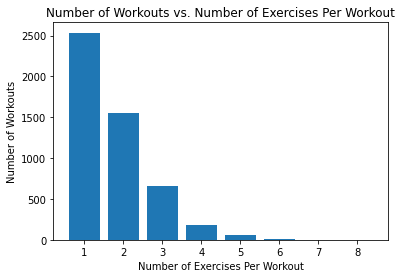

0.5067972810875649


In [271]:
# Get all unique excercises per workout
def get_unique_exercises_per_workout(df, workout_column, exercise_column):
    all_workouts = set(df[workout_column])
    workouts_to_exercises = {}
    for workout in all_workouts:
        workout_information = df.loc[df[workout_column] == workout]
        workouts_to_exercises[workout] = set(workout_information[exercise_column])
    return workouts_to_exercises

workouts_to_exercises = get_unique_exercises_per_workout(fitbod_data, "workoutId", "exerciseName")

# Get distribution of number of exercises per workout
counts = defaultdict(int)
for exercises in workouts_to_exercises.values():
    counts[len(exercises)] += 1

plt.bar(counts.keys(), counts.values())
plt.xlabel("Number of Exercises Per Workout")
plt.ylabel("Number of Workouts")
plt.title("Number of Workouts vs. Number of Exercises Per Workout")
plt.show()

print(counts[1]/sum(counts.values()))

It would appear that most workouts (over 50%!) consist of only one exercise. Since this doesn't align with how I personally imagine the app to be used, I would want to dig deeper into this data to determine why people are doing so many 1-exercise workouts.

#### How many users have logged a workout consisting of only one exercise?

In [85]:
users_logging_one_exercise = set([fitbod_data.loc[fitbod_data.workoutId == _id].fakeUserId.values[0] for _id, exercises in workouts_to_exercises.items() if len(exercises) > 1])
len(users)/fitbod_data.fakeUserId.nunique()

0.9863013698630136

It appears that 99% of users have logged workouts that consist of only one workout. So, at least according to this dataset, single exercise workouts are a common occurance.

#### What exercises are making up these single exercise workouts?

In [90]:
exercises = list(workouts_to_exercises.values())
single_exercises = list(map(lambda x: x.pop(), filter(lambda x: len(x) == 1, exercises)))
counter = Counter(single_exercises)
counter.most_common(5)

[('Back Squat', 154),
 ('Barbell Incline Bench Press', 129),
 ('Bent Over Barbell Row', 116),
 ('Leg Raise', 106),
 ('Dumbbell Rear Delt Raise', 91)]

The most common single exercise is the `Back Squat` which is in a category of exercises known as "Olympic lifts" or "Powerlifts". It is reasonable to think that someone wanting to improve some aspect of their squat would only do that exercise as a part of a workout. However, the other exercises in the top 5 single exercise workouts as not "Olympic lifts" and I'm not sure why anyone would do, for example, a single set of `Leg Raise`. I would want to investigate this further, but it requires data beyond that in this dataset. Specifically, I'd want the following:
* **Duration** of each workout in order to confirm that the timing makes sense with completing a single exercise. If too short or too long, it's a sign that something is abnormal.
* **More entries** in order to determine if this is a small phenomenon with respect to *all* users.
* **User interviews** would be beneficial, if all else checks out. Perhaps the users are using the app in a way that we don't current expect, but could work towards accomodating even better in the future

#### What is the most logged exercise?

In [73]:
exercise_group = fitbod_data.groupby(by="exerciseName").size()
print(f"Most logged exercise: {exercise_group.idxmax()}")
print(f"Least logged exercise: {exercise_group.idxmin()}")

Most logged exercise: Back Squat
Least logged exercise: Kettlebell Pistol Squat


No surprise, `Back Squat` is the most logged exercise.

Follow up questions: Why might the `Kettlebell Pistol Squat` be used so infrequently? Did the app just not suggest it to them very often or did users just not select it often?

#### Since `Back Squat` is the most logged, in large part due to single exercise workouts, what is the second most logged exercise?

In [97]:
new_exercise_group = exercise_group.drop(exercise_group.idxmax())
new_exercise_group.idxmax()

'Leg Raise'

`Leg Raise` must be popular not only as a single exercise workout, but as a supplementary exercise in multi-exercise workouts, as well, because it takes second place.

#### What are the most logged exercise pairings?

In [104]:
exercise_pairs = defaultdict(int)
for exercises in filter(lambda x: len(x) > 1, workouts_to_exercises.values()):
    for combo in combinations(exercises, 2):
        sorted_combo = sorted(combo)
        exercise_pairs[(sorted_combo[0], sorted_combo[1])] += 1

most_pairs = max(exercise_pairs.items(), key=lambda x: x[1])
top_3_pairings = sorted(exercise_pairs.items(), key=lambda x: x[1], reverse=True)[:3]
top_3_pairings

[(('Dumbbell Rear Delt Raise', 'Dumbbell Shoulder Raise'), 48),
 (('Decline Push Up', 'Tricep Push Up'), 38),
 (('Back Squat', 'Romanian Deadlift'), 31)]

The top three most logged pairings appear to be complementary in nature. `Back Squats` and `Romanian Deadlifts` as a pair is expected, as this is a pairing in Powerlifting [competitions](https://www.issaonline.com/blog/index.cfm/2021/beginners-guide-to-powerlifting-lifts-competitions-judges). The others seem to be grouped by muscle group being exercised, which is a common practice for lifting weights.

### 2. User data

#### Who is the most active user?

In [107]:
fbm[["workoutId", "fakeUserId"]].groupby(by="fakeUserId").count().idxmax().values[0]

'fake_id_550'

User `fake_id_550` is our most active user. I'd suggest sending them some free marketing materials (T-shirt, waterbottle) as an accomplishment and/or invite them to participate in testing out our beta features. We could do a blog post on `fake_id_550` (with their consent) to perhaps increase users' motivation to use the app often.

####  Are users improving over time? 
For the purposes of this investigation "improving" will be equated to increasing the number of reps and or the number of weights for a certain exercise over time.

/Users/jcummings/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


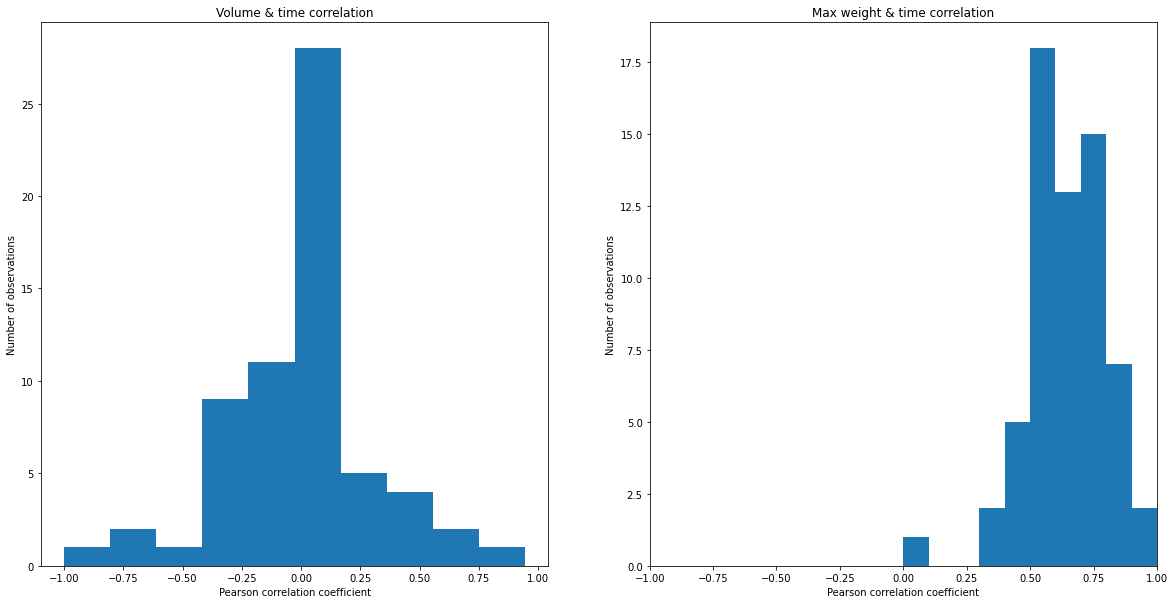

In [370]:
def average_corr(corr):
    return np.mean(list(filter(lambda x: not np.isnan(x), corr.values())))

def get_correlations(df, exercise_column, time_column):
    vc = {}
    mc = {}
    for exercise in set(df[exercise_column]):
        user_data_for_cp = df.loc[df[exercise_column] == exercise]
        max_weight = 0.0
        all_max_weights = []
        for _, row in user_data_for_cp.iterrows():
            max_weight = max(row["weight"], max_weight)
            all_max_weights.append(max_weight)
        user_data_for_cp["max_weight"] = all_max_weights
        mc[exercise] = user_data_for_cp[time_column].corr(user_data_for_cp.max_weight)
        vc[exercise] = user_data_for_cp[time_column].corr(user_data_for_cp.volume)
    return vc, mc


all_correlations_volume = []
all_correlations_max = []
for user in set(fitbod_data.fakeUserId):
    user_data = fitbod_data.loc[fitbod_data.fakeUserId == user].sort_values(by="date")
    user_data["volume"] = user_data.reps * user_data.weight

    volume_corr, max_corr = get_correlations(user_data, "exerciseName", "month")
        
    all_correlations_volume.append(average_corr(volume_corr))
    all_correlations_max.append(average_corr(max_corr))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.hist(all_correlations_volume, bins=10)
ax1.set_xlabel("Pearson correlation coefficient")
ax1.set_ylabel("Number of observations")
ax1.set_title("Volume & time correlation")
ax2.hist(all_correlations_max, bins=10)
ax2.set_xlabel("Pearson correlation coefficient")
ax2.set_ylabel("Number of observations")
ax2.set_title("Max weight & time correlation")
ax2.set_xlim([-1, 1])
plt.show()

On average, there's no correlation between time and volume. There appears to be a stronger correlation between `max_weight` and time.

### 3. Modeling 

As it was pointed out earlier, there is not a clear modeling task that could be derived from the dataset and perform with exceptional accuracy. However, I wanted to explore a very basic recommendation system based on the available data. For this, I made the following simplifying assumptions:
* Exercise 1 and Exercise 2 are complementary if they exist in the same workout
* Exercise 1 is the only factor that affects the determination of Exercise 2

First, let's create a co-occurance matrix

In [231]:
exercises = fitbod_data.exerciseName.unique()
co_occur_matrix = {ex1: {ex2: 0. for ex2 in exercises} for ex1 in exercises}

for workout, exs in workouts_to_exercises.items():
    all_co_occur = permutations(exs, 2)
    for perm in all_co_occur:
        co_occur_matrix[perm[0]][perm[1]] += 1

co_occur_pd = pd.DataFrame(np.array([list(v.values()) for v in co_occur_matrix.values()]), index=co_occur_matrix.keys(), columns=co_occur_matrix.keys())

The first naive recommendation system simply takes the largest value in the co-occurance matrix based on the exercise given to the function.

In [242]:
def naive_recommendation(first_exercise):
    return co_occur_pd[first_exercise].idxmax()

naive_recommendation("Decline Push Up")

'Tricep Push Up'

The system recommends `Tricep Push Up`, which we know is logged many, many times in our dataset. To avoid almost always getting `Back Squat` or `Tricep Push Up`, we need to normalize the values by the amount of times they show up in the entire dataset. For this, I use the "Jaccard" similarity metric.

In [241]:
# Jaccard similarity (i & j / i | j)
co_occur_pd_jaccard = co_occur_pd.apply(lambda x: x/x.sum()).apply(lambda x: x/x.sum(), axis=1)

def jaccard_recommendation(first_exercise):
    return co_occur_pd_jaccard[first_exercise].idxmax()

jaccard_recommendation("Decline Push Up")

'Floor Press'

Great! Now we get another exercise that also works the Pectoral muscles, which means it's likely to be a good exercise to do alongside `Decline Push Up`. But what if we want to know what exercise to do after `Pull Up`s, which aren't currently listed in the dataset? I first check if the exercise is in the dataset and if not, I recommend the max value in the co-occurence matrix.

In [259]:
# Cold start problem
def cs_jaccard_recommendation(first_exercise):
    if first_exercise not in co_occur_pd_jaccard.index:
        return co_occur_pd_jaccard.max().idxmax()
    return co_occur_pd_jaccard[first_exercise].idxmax()

cs_jaccard_recommendation("Pull Up")

'TRX Pulse Lunges'

The last problem to tackle is the issue of variability. A user likely does not want to *always* do `Floor Press` when they do `Decline Push Up`. Therefore, I add a little bit of noise to the measurements.

In [269]:
# No variation
def recommendation(first_exercise, noise=0.01):
    new_pd = co_occur_pd_jaccard.apply(lambda x: x + np.random.uniform(low=-noise, high=noise), axis=1)
    if first_exercise not in new_pd.index:
        return new_pd.max().idxmax()
    return new_pd[first_exercise].idxmax()

for i in range(10):
    print(recommendation("Decline Push Up"))

Floor Press
Floor Press
Floor Press
Floor Press
Handle Band Pec Fly
Floor Press
Floor Press
Floor Press
Floor Press
Floor Press


Viola! We now have a very basic exercise recommendation system. Some potential improvements are as follows:
* User data: Currently we know nothing about the users' characteristics or their workout goals. By ingesting this information, we could recommend workouts also based on similar users.
* Using more exercises as a starting point: The assumption that only one exercise affects the exercise recommended was used to simplify the experiment, but is not indicative of a real-world experience.
* More data

***
### Looking at my own data

In [371]:
joe_data = pd.read_csv("WorkoutExport.csv", parse_dates=["Date"])

Looks like my data is structured a little differently

In [372]:
joe_data["volume"] = joe_data.Reps * joe_data["Weight(kg)"]
joe_data = joe_data.rename(columns={"Weight(kg)": "weight"})
joe_data["month"] = joe_data.Date.dt.month
joe_data["date_as_int"] = joe_data.Date.astype(np.int64) #joe_data.Date.astype("int") / 10**9

Let's see how I've been improving over time...

/Users/jcummings/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


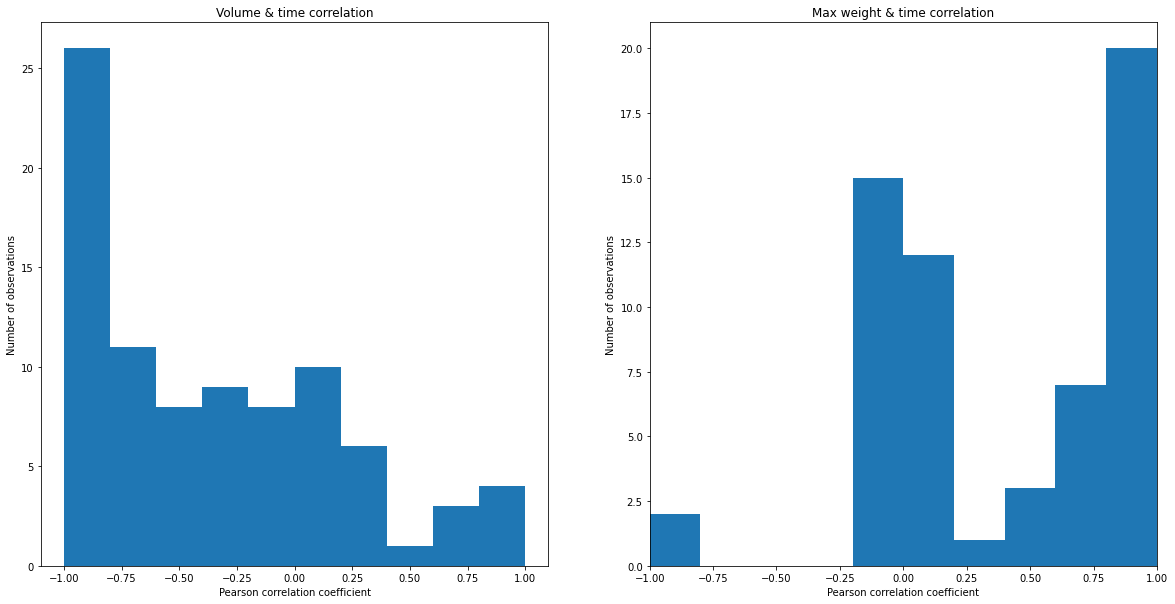

In [373]:
joe_volume_corr, joe_max_corr = get_correlations(joe_data.sort_values(by="Date"), "Exercise", "date_as_int")

joe_all_correlations_volume = list(filter(lambda x: not np.isnan(x), joe_volume_corr.values()))
joe_all_correlations_max = list(filter(lambda x: not np.isnan(x), joe_max_corr.values()))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.hist(joe_all_correlations_volume, bins=10)
ax1.set_xlabel("Pearson correlation coefficient")
ax1.set_ylabel("Number of observations")
ax1.set_title("Volume & time correlation")
ax2.hist(joe_all_correlations_max, bins=10)
ax2.set_xlabel("Pearson correlation coefficient")
ax2.set_ylabel("Number of observations")
ax2.set_title("Max weight & time correlation")
ax2.set_xlim([-1, 1])
plt.show()

Oof, looks like the pandemic really had an affect on my exercise improvement. Maybe I should get to a gym in 2022.